In [2]:
import cv2
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import mean_squared_error
import random

In [3]:
path = "input/FER"

faceFiles = [
    *glob.glob(f"../{path}/train/**/*.jpg")
]

In [4]:
print(len(faceFiles))

981


In [5]:
pics = dict()
for foto in faceFiles:
    label = foto.split("/")[-2]
    pic = foto
    if label in pics:
        pics[label].append(pic)
    else:
        pics[label] = [pic]

In [6]:
im = []
for k,v in pics.items():
    for a in v:
        im.append([k,a])
faces_df =  pd.DataFrame(im, columns=["mood","photo"])
display(faces_df)

,mood,photo
0,happy,../input/FER/train/happy/S085_002_00000013.jpg
1,happy,../input/FER/train/happy/S011_006_00000013.jpg
2,happy,../input/FER/train/happy/S060_002_00000025.jpg
3,happy,../input/FER/train/happy/S137_011_00000020.jpg
4,happy,../input/FER/train/happy/S037_006_00000020.jpg
...,...,...
976,disgust,../input/FER/train/disgust/S128_004_00000011.jpg
977,disgust,../input/FER/train/disgust/S068_005_00000021.jpg
978,disgust,../input/FER/train/disgust/S056_002_00000009.jpg
979,disgust,../input/FER/train/disgust/S077_006_00000014.jpg


In [7]:
import random
who = random.choice(faces_df.mood)
missing = pics[who]

In [8]:
faces_df.mood.value_counts()

surprise    249
happy       207
disgust     177
anger       135
sadness      84
fear         75
contempt     54
Name: mood, dtype: int64

[(2, 7, 43, 41)]


array([[  0,   0,  10, ...,  91,  66,   8],
       [  0,   0,  14, ...,  96,  79,  15],
       [  0,   4,  27, ...,  96,  75,  24],
       ...,
       [  0,   7,   9, ..., 147,  44,  22],
       [  1,   2,   2, ..., 159,  39,  33],
       [  0,   0,  18, ..., 171,  46,  10]], dtype=uint8)

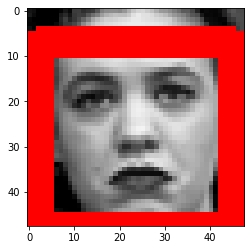

In [9]:
import matplotlib.pyplot as plt
import cv2
import face_recognition

face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

def extractFace(picFile, method="recognition", debug=False):
    im = cv2.imread(picFile)    
    im_bw = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    plt.imshow(im_bw, cmap="gray")
    # Face detection, OJO: esto detecta multiples caras
    if method == "recognition":
        faces = face_recognition.face_locations(im_bw)
        faces = [(l,t,r-l,b-t) for t,r,b,l in faces]
    else:
        faces = face_cascade.detectMultiScale(im_bw, 2, 4)

    if len(faces) == 0:
        print(f"Warning: no face detected on {picFile}")
        return 
    
    if debug:
        print(faces)
    selected_face = faces[0]
    discard_faces = faces[1:]
    
    if debug:
        debug_squares = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        # plot the invalid squares in blue
        for face in discard_faces:
            x,y,w,h = face
            debug_squares = cv2.rectangle(debug_squares, (x,y), (x+w,y+h),(0, 0, 255) ,5)
        # plot the selected face in red
        x,y,w,h = selected_face
        debug_squares = cv2.rectangle(debug_squares, (x,y), (x+w,y+h),(255, 0, 0) ,5)

        plt.imshow(debug_squares)

            
    # extract selected face as B&W 
    x,y,w,h = selected_face
    cara = im_bw[y:y+h,x:x+h]    
    return cara

    
    
    
extractFace(missing[1], debug=True)

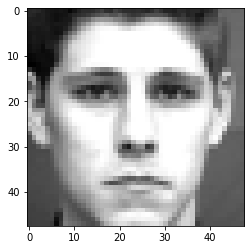

In [10]:
missingFaces = [extractFace(missingPic) for missingPic in missing]


In [11]:
missingFaces = [a for a in missingFaces if isinstance(a, np.ndarray)]

In [12]:
dim = (100,100)
missingNormalized = [cv2.resize(a, dim, interpolation=cv2.INTER_AREA) for a in missingFaces]

In [14]:
x = [a.shape for a in missingNormalized]
x[0]

(100, 100)

In [15]:
# Wrap all in one fn
def processFiles(files, dim=(100,100)):
    output_faces = []
    for incomingFile in files: 
        face = extractFace(incomingFile)
        if  isinstance(face, np.ndarray):
            face = cv2.resize(face, dim, interpolation=cv2.INTER_AREA)
            output_faces.append(face)
    return output_faces


array([-0.16719362,  0.03262519,  0.10202745, -0.05968413, -0.16040987,
       -0.07042313, -0.0348452 , -0.17429294,  0.08964369, -0.05286901,
        0.26626718, -0.09543771, -0.18142329, -0.10603383,  0.02693162,
        0.1668742 , -0.12638789, -0.13382554, -0.01359598, -0.02451158,
       -0.09672549, -0.01481173,  0.06839988,  0.07742958, -0.07578271,
       -0.3211883 , -0.09598601, -0.09312396,  0.00199322, -0.04322404,
        0.0139872 ,  0.18039425, -0.22105512, -0.02320634,  0.00566436,
        0.07103317,  0.00081857, -0.06630677,  0.18733126, -0.01830021,
       -0.22057971, -0.11409183,  0.03607417,  0.19849654,  0.15859294,
       -0.04026635,  0.00205034, -0.01046285,  0.02913194, -0.19607225,
        0.02556873,  0.11120892,  0.15231864, -0.05689457, -0.04759737,
       -0.13380502, -0.00941807,  0.06636135, -0.16171427, -0.06890211,
        0.05649669, -0.05060828, -0.07458638, -0.06196838,  0.30001041,
        0.15992743, -0.0963465 , -0.09568343,  0.19721082, -0.05

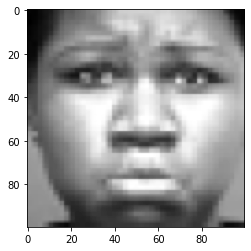

In [17]:
import face_recognition

def extractFeatures(faceIm, useFeats="face",debug=False):
    if debug:
        plt.figure()
        plt.imshow(faceIm, cmap="gray")
    if useFeats == "fft":
        fft2d = np.log(np.abs(np.fft.fft2(faceIm)))
        fft2d = fft2d[0:len(fft2d)//2,0:len(fft2d)//2]
        fft2d = fft2d[5:20,5:20]
        
        if debug:
            plt.figure()
            plt.imshow(fft2d, cmap="gray")
            print(fft2d.shape)
        
        return np.hstack(fft2d)
    elif useFeats == "face":
        imcol = cv2.cvtColor(faceIm, cv2.COLOR_GRAY2RGB)
        feats = face_recognition.face_encodings(imcol)
        if len(feats) > 0:
            return feats[0]
        return None
    
extractFeatures(missingNormalized[0], debug=True)

Processing happy....
Processing contempt....
Processing fear....
Processing surprise....
Processing sadness....
Processing anger....
Processing disgust....


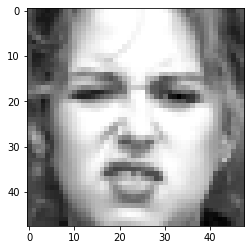

In [18]:
featurized_dataset = []
for mood,photo in pics.items():
    faces = processFiles(photo)
    print(f"Processing {mood}....")
    for i,face in enumerate(faces):
        featurized_dataset.append({
            "mood":mood,
            "picName":i,
            "feats":extractFeatures(face)
        })

In [19]:
df = pd.DataFrame(featurized_dataset)
df

,mood,picName,feats
0,happy,0,"[-0.0857856497168541, 0.12070325762033463, 0.0..."
1,happy,1,"[-0.11561565101146698, 0.10042160749435425, 0...."
2,happy,2,"[-0.08078758418560028, 0.0004498511552810669, ..."
3,happy,3,"[-0.1381092220544815, 0.04767180234193802, 0.1..."
4,happy,4,"[-0.05357274413108826, 0.08892941474914551, 0...."
...,...,...,...
976,disgust,172,"[-0.09853385388851166, 0.03188201040029526, -0..."
977,disgust,173,"[-0.1351788192987442, -0.017433062195777893, 0..."
978,disgust,174,"[-0.12328560650348663, 0.09153527021408081, -0..."
979,disgust,175,"[-0.2434164434671402, 0.08779747039079666, 0.0..."


In [20]:
df.mood.value_counts()

surprise    249
happy       207
disgust     177
anger       135
sadness      84
fear         75
contempt     54
Name: mood, dtype: int64

In [22]:
df = df[~df.feats.isna()]

In [26]:
df.feats.isna().value_counts()

False    978
Name: feats, dtype: int64

In [27]:
y = df.mood
X = np.vstack(df.feats)

In [28]:
print(X.shape,y.shape)

(978, 128) (978,)


In [29]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)
y_numeric

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2)

In [31]:
model = KNeighborsClassifier()

model.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
model.predict(X_test)

array([4, 6, 3, 2, 4, 1, 4, 6, 3, 3, 4, 0, 5, 2, 5, 3, 1, 1, 1, 2, 2, 4,
       4, 2, 3, 4, 6, 2, 5, 6, 2, 2, 0, 3, 6, 6, 4, 2, 4, 2, 6, 4, 2, 3,
       5, 3, 4, 2, 5, 2, 0, 5, 0, 2, 4, 0, 5, 5, 4, 3, 0, 6, 0, 5, 5, 2,
       5, 4, 6, 2, 6, 0, 3, 4, 3, 4, 1, 4, 3, 3, 1, 2, 2, 2, 6, 6, 4, 4,
       4, 6, 0, 0, 2, 0, 1, 6, 5, 4, 4, 2, 2, 1, 6, 3, 6, 3, 5, 2, 4, 3,
       4, 0, 0, 0, 5, 6, 3, 2, 3, 2, 5, 4, 3, 6, 6, 2, 4, 0, 4, 6, 6, 2,
       1, 3, 0, 5, 5, 2, 2, 6, 2, 1, 3, 0, 6, 2, 5, 0, 6, 3, 0, 6, 0, 2,
       0, 3, 4, 0, 2, 2, 0, 2, 2, 4, 6, 6, 6, 3, 4, 3, 2, 2, 3, 0, 6, 3,
       4, 4, 1, 5, 1, 4, 0, 6, 2, 0, 1, 0, 0, 6, 5, 4, 2, 4, 2, 5])

In [33]:
y_pred = model.predict(X_test)
pd.DataFrame({
    "pred": le.inverse_transform(y_pred),
    "real": le.inverse_transform(y_test)
})

,pred,real
0,happy,disgust
1,surprise,happy
2,fear,happy
3,disgust,disgust
4,happy,surprise
...,...,...
191,happy,fear
192,disgust,disgust
193,happy,happy
194,disgust,disgust


In [34]:
print(mean_squared_error(y_test, y_pred, squared=False))

2.378689400763816


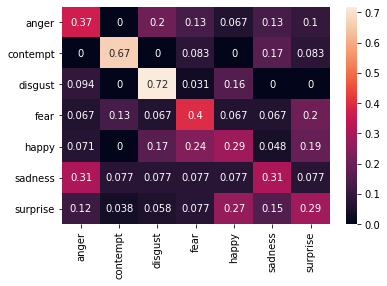

In [35]:
cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred), normalize="true")
sns.heatmap(cm, annot=True,xticklabels=le.classes_, yticklabels=le.classes_)

## Test

In [51]:
path = "input/FER"

faceFiles_test = [
    *glob.glob(f"../{path}/test/**/*.jpg")
]


In [37]:
pics = dict()
for foto in faceFiles_test:
    label = foto.split("/")[-2]
    pic = foto
    if label in pics:
        pics[label].append(pic)
    else:
        pics[label] = [pic]

In [38]:
im = []
for k,v in pics.items():
    for a in v:
        im.append([k,a])
facestest_df =  pd.DataFrame(im, columns=["mood","photo"])
display(facestest_df)

,mood,photo
0,Happy,../input/FER/test/Happy/35837.jpg
1,Happy,../input/FER/test/Happy/32802.jpg
2,Happy,../input/FER/test/Happy/33249.jpg
3,Happy,../input/FER/test/Happy/35638.jpg
4,Happy,../input/FER/test/Happy/33507.jpg
...,...,...
3582,Disgust,../input/FER/test/Disgust/35391.jpg
3583,Disgust,../input/FER/test/Disgust/33284.jpg
3584,Disgust,../input/FER/test/Disgust/33481.jpg
3585,Disgust,../input/FER/test/Disgust/35580.jpg


In [39]:
whotest = random.choice(facestest_df.mood)
missingtest = pics[whotest]

In [40]:
facestest_df.mood.value_counts()

Happy       879
Neutral     626
Sad         594
Fear        528
Angry       490
Surprise    416
Disgust      54
Name: mood, dtype: int64

array([[ 44,  34,  21, ..., 231, 232, 233],
       [ 40,  30,  19, ..., 228, 228, 227],
       [ 37,  29,  15, ..., 223, 222, 222],
       ...,
       [ 16,   8,  14, ..., 153, 176, 170],
       [ 18,  41,  56, ..., 139, 163, 182],
       [ 33,  65,  86, ..., 127, 149, 176]], dtype=uint8)

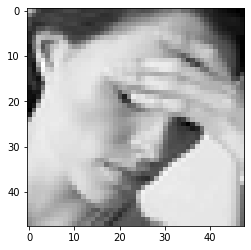

In [64]:
missingFacestest = [extractFace(missingPic) for missingPic in missingtest]

missingFacestest[0]

In [42]:
missingFacestest = [a for a in missingFacestest if isinstance(a, np.ndarray)]

In [43]:
dim = (100,100)
missingNormalizedtest = [cv2.resize(a, dim, interpolation=cv2.INTER_AREA) for a in missingFacestest]

In [44]:
[a.shape for a in missingNormalizedtest]

[(100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),

Processing Happy....


Processing Sad....


Processing Fear....


Processing Surprise....


Processing Neutral....


Processing Angry....
Processing Disgust....


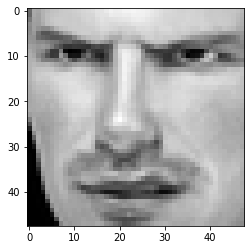

In [45]:
featurized_dataset_test = []
for mood,photo in pics.items():
    faces = processFiles(photo)
    print(f"Processing {mood}....")
    for i,face in enumerate(faces):
        featurized_dataset_test.append({
            "mood":mood,
            "picName":i,
            "feats":extractFeatures(face)
        })

In [89]:
df_test = pd.DataFrame(featurized_dataset_test)
df_test

,mood,picName,feats
0,Happy,0,"[-0.15079370141029358, 0.08521832525730133, 0...."
1,Happy,1,"[-0.04228217154741287, 0.11752933263778687, 0...."
2,Happy,2,"[-0.12527117133140564, 0.1283390074968338, 0.1..."
3,Happy,3,"[-0.07098225504159927, 0.07343848794698715, 0...."
4,Happy,4,"[-0.10159466415643692, 0.13450399041175842, -0..."
...,...,...,...
2460,Disgust,37,"[-0.07191365212202072, 0.19906409084796906, 0...."
2461,Disgust,38,"[-0.12529252469539642, 0.09248815476894379, 0...."
2462,Disgust,39,"[-0.16098885238170624, -0.0334506630897522, 0...."
2463,Disgust,40,"[-0.14776591956615448, 0.03923516720533371, 0...."


In [90]:
df_test.mood.value_counts()

Happy       690
Neutral     471
Fear        331
Angry       330
Sad         302
Surprise    299
Disgust      42
Name: mood, dtype: int64

In [91]:
df_test = df[~df.feats.isna()]

In [92]:
le = preprocessing.LabelEncoder()
df_test['mood']= le.fit_transform(df_test.mood)


In [93]:
df_test

,mood,picName,feats
0,4,0,"[-0.0857856497168541, 0.12070325762033463, 0.0..."
1,4,1,"[-0.11561565101146698, 0.10042160749435425, 0...."
2,4,2,"[-0.08078758418560028, 0.0004498511552810669, ..."
3,4,3,"[-0.1381092220544815, 0.04767180234193802, 0.1..."
4,4,4,"[-0.05357274413108826, 0.08892941474914551, 0...."
...,...,...,...
976,2,172,"[-0.09853385388851166, 0.03188201040029526, -0..."
977,2,173,"[-0.1351788192987442, -0.017433062195777893, 0..."
978,2,174,"[-0.12328560650348663, 0.09153527021408081, -0..."
979,2,175,"[-0.2434164434671402, 0.08779747039079666, 0.0..."


In [94]:
y_pred = model.predict(x)

In [97]:

df_test2 = pd.DataFrame({
    "GT":  df_test['mood'] ,
    "y_pred" : y_pred,
    "dif": df_test['mood']-y_pred
})
df_test2

,GT,y_pred,dif
0,4,4,0
1,4,4,0
2,4,4,0
3,4,4,0
4,4,4,0
...,...,...,...
976,2,2,0
977,2,2,0
978,2,2,0
979,2,2,0


In [103]:
df_test2.dif.value_counts()[0]/len(df_test2)

0.7147239263803681

In [104]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_true, y_pred))